# Sustainable Heating & Cooling project 

## Task 1
Simulate the Pasta cooking step of the pasta cooker 

#### Data and Package importation: 

In [7]:
from pylab import *
from Compressor_model import recip_comp_SP
from scipy.integrate import odeint
from scipy.optimize import  minimize,NonlinearConstraint #optimization
import CoolProp.CoolProp as CP
import plotDiag_Th_Ts as Diag
import matplotlib.pyplot as plt
import numpy as np
from math import pi, log
import Fluid_CP as FCP #calculation of  thermodynamic states
import pandas as pd

In [8]:
sim_duration = 12 * 3600      # [s] total simulation time (12 h)

# === Pasta cooking parameters ===
m_pasta_batch   = 2.0         # [kg] pasta per batch
m_pasta_basket  = 0.5         # [kg] pasta per basket
n_baskets       = 4.0         # number of pasta baskets
t_env           = 20.0        # [°C] outside temperature
t_p_0           = 7.0         # [°C] initial pasta temperature
t_p_tgt         = 85.0        # [°C] cooking temperature 
t_w_init        = 20.0        # [°C] ambient start temperature 
t_w_min         = 85.0        # [°C] lower control bound 
t_w_max         = 93.0        # [°C] upper control bound 
t_cook          = 7 * 60      # [s] cooking time per batch 
t_break         = 5 * 60      # [s] break between batches 

# === Thermal resistances ===
r_env_water   = 30.0          # environment ↔ water 
r_water_pasta = 15.0          # water ↔ pasta 

# === Specific heats ===
cp_water = 4.18            # [kJ/kg/K] water 
cp_pasta = 3.5              # [kJ/kg/K] pasta 

# === Cooker Dimensions ===
W_ext = 0.27 #[m]
L_ext = 0.47 #[m]
W_in = 0.10 #[m]
L_in = 0.20 #[m]
H_ext = 0.20 #[m]
H_in = 0.15 #[m]
wall_thick = 0.02 #[m]
# === Condenser dimensions ===
d_o=0.0635 # outer tube diameter [m]
d_i =0.0473 # inner tube diameter [m]
d_w = 0.0008 # tube wall thickness [m]


delta_sc = 0 # We consider no supercooling in the condenser

#### On-off strategy and determination of the required heating power during the pasta cooking phase

In [41]:
def calc_WP(T,T_WP_on,T_WP_off,op_times,QHP):
    global WP,time
    if WP==0 and T>T_WP_on:
        Q_WP=0. #kW WP off
        WP=0
        #time=0
    if WP==0 and T<=T_WP_on:
        Q_WP=QHP #kW WP switched on
        WP=1 #1=WP on
        time+=1
    if WP==1 and T<=T_WP_off:
        Q_WP=QHP #kW WP on
        time+=1
    if WP==1 and T>T_WP_off:
        Q_WP=0. #kW WP switched off
        WP=0
        op_times.append(time)
        time=0
    return Q_WP

In [42]:
def temp_water_pasta(T,t,Q_WP):
    Tw,Tp = T
    return [(-1/(mw*cp_water))*((1/r_water_pasta)*(Tw - Tp) + (1/r_env_water)*(Tw - t_env))  + (1/(mw*cp_water))*Q_WP,(1/(r_water_pasta*m_pasta_batch*cp_pasta))*(Tw - Tp)]

In [43]:
def T_water_pasta(T_WP_on,T_WP_off,n,op_times,Qhp):
    QHP = Qhp #kW heat pump power
    #initial storage temperature
    T0 = (t_w_max,t_p_0) #fully charged
    # time points
    t = linspace(0,n,n)
    # store storage temperature
    T=np.zeros((n,2))
    # save initial storage temperature
    T[0,0] = t_w_max
    T[0,1] = t_p_0
    
    # heat pump
    Q_WPs=zeros(n) #store power of heat pump
    Q_WPs[0]=0 #kW power of heat pump at t=0 is 0 kW

    # solve differential equation for the storage temperature
    for i in range(1,n):
        # span for next time step
        tspan = [t[i-1],t[i]]
        # solve for next step
        z = odeint(temp_water_pasta,T0,tspan,args=(Q_WPs[i-1],))
        #heat pump power for netxt time step
        Q_WPs[i]=calc_WP(z[1,0],T_WP_on,T_WP_off,op_times,QHP)
        # store storage temperature
        T[i,0] = z[1,0]
        T[i,1] = z[1,1]
        # next initial condition
        T0 = (z[1,0],z[1,1])
    
    # plot results    
    #fig, ax1 = plt.subplots()
    #ax2 = ax1.twinx()
    #ax1.plot(t,T,'r--',label='T_store')
    #ax2.plot(t,Q_WPs,'g:',label='Q_WP')
    #ax1.set_xlabel('time in seconds')
    #ax1.set_ylabel('T_store in °C', color='r')
    #ax2.set_ylabel('Q_WP in kW', color='g')
    #plt.show()


    # plot results only for optimal heat pump operation 
    if QHP == 3.5:    
        fig, (ax1,ax2,ax3) = plt.subplots(3,sharex=True)
        
        ax1.plot(t,T[:,0],'r--',label='T_store')
        ax2.plot(t,Q_WPs,'g:',label='Q_WP')
        ax2.set_xlabel('time in seconds')
        ax1.set_ylabel('T_store in °C', color='r')
        ax2.set_ylabel('Q_WP in kW', color='g')
        ax3.plot(t,T[:,1],'b-',label='T_pasta')
        ax3.set_ylabel('T_pasta in °C', color='b')
        plt.show()

    
    
    return t,Q_WPs,T

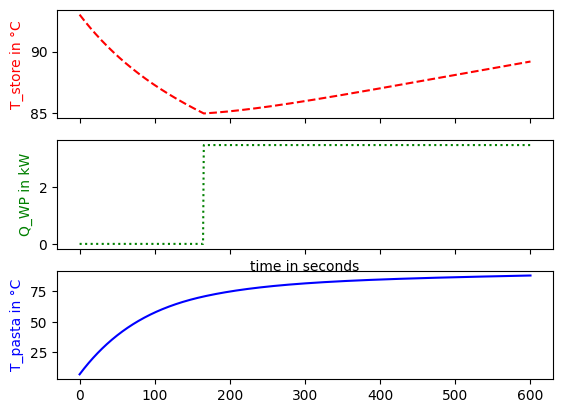

Required heating power: 3.5kW


In [44]:
n = 10*60 # number of time steps, 10 minutes in seconds

Qhpmat = np.zeros((int(5/0.1)+1,2)) # matrix for heat pump power, operating time and number of times heat pump was switched on

for i in np.arange(0,5,0.1):
    global time, WP, op_times1

    #conditions
    Qhpmat[int(i/0.1), 0] = i
    mw = 26.6*46.6*19.8*(10**-6)*1000 
    T_WP_off1=93 #°C
    T_WP_on1=85 #°C
    V_store1=200 #L
    R=1.8 #m2·K/W

    #initial values
    time=0 #HP is not running at the t=0
    WP=0 #heat pump is switched off at t=0
    op_times1=list() #list for operating times

    #caltulation temperature profile and heat pump operating times
    t1,Q_WPs1,T1=T_water_pasta(T_WP_on1,T_WP_off1,n,op_times1,Qhpmat[int(i/0.1), 0])

    Qhpmat[int(i/0.1), 1] = T1[420,1]
    #if heat pump is running at the end of the time range, the runnig time is added to the list
    if time!=0:
        op_times1.append(time)
    #print("Min operating time=",round(min(op_times1)/60.,2),"minutes")
    #print("Max operating time=",round(max(op_times1)/60.,2),"minutes")
    #print("Number of times heat pump was switched on=",len(op_times1))
    #print(T1[420,1]) 

    
# Find the first index where the pasta temperature is >= 85°C
idx = np.argmax(Qhpmat[:, 1] >= 85)
if Qhpmat[idx, 1] >= 85:
    print(f"Required heating power: {Qhpmat[idx,0]}kW")
else:
    print("No value found where pasta temp >= 85°C")


In [45]:
# le mettre sous la forme d'une fonction 
#all dimensions in [mm]
pipe_diameter = 6.35
length_available = 466
height_available = 48
width_available = 266

number_of_pipes_1 = (length_available // pipe_diameter) 
L_cond_max_1 = (number_of_pipes_1 * width_available) /1000  # [m] maximum length of the condenser
print(f"Max Lcond config 1 with {number_of_pipes_1:.0f} pipes and a total Lenght of {L_cond_max_1:.2f} m")
# or other option
number_of_pipes_2 = (width_available // pipe_diameter) 
L_cond_max_2 = (number_of_pipes_2 * length_available) / 1000
print(f"Max Lcond config 2 with {number_of_pipes_2:.0f} pipes and a total Lenght of {L_cond_max_2:.2f} m")
# so we choose th the longest option between the two 
L_cond_max = max(L_cond_max_1, L_cond_max_2)
print(f"Max L cond is {L_cond_max:.2f} m")

Max Lcond config 1 with 73 pipes and a total Lenght of 19.42 m
Max Lcond config 2 with 41 pipes and a total Lenght of 19.11 m
Max L cond is 19.42 m


## Task.2

In [30]:
#refrigerant
delta_T_sh=10. #K #superheating #determined by us
delta_T_sc=5. #K #subcooling #determined by us
fluid="R1234yf"
Eh="CBar"

#source
fluid_so="air"
T_so=20. #°C

#sink
fluid_si="water"
T_si_in=85. #°C
T_si_out=93. #°C

#heat exchanger
min_pinch=0.5 #K

In [31]:
def calc_COP(param, fluid, D):
    T_co,T_ev=param
    eta_is,_ = recip_comp_SP([T_ev,T_co,delta_T_sh,delta_T_sc,D],fluid,transcrit=False)
    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat

    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)

    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=FCP.state(["p","h"],[state1["p"],state3["h"]],fluid,Eh)

    #spec. heat released in the condenser
    q_high=state2["h"]-state3["h"] #kJ/kg
    #spec. compressor work
    w_comp=state2["h"]-state1["h"]  #kJ/kg
    #coefficient of performance 
    COP=q_high/w_comp
    #return reciprocal value of COP
    return 1./COP

In [32]:
def pinch_evap(param, fluid, D):
    T_co,T_ev=param
    eta_is,m_dot = recip_comp_SP([T_ev,T_co,delta_T_sh,delta_T_sc,D],fluid,transcrit=False)
    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat
    
    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)
    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=FCP.state(["p","h"],[state1["p"],state3["h"]],fluid,Eh)
    
    ##### Evaporator outlet
    #The temperature difference at the outlet of the evaporator *delta_T_out_ev* is the difference 
    delta_T_out_ev=T_so-state1["T"]
    
    ##### Evaporator inlet
    #The temperature difference at the inlet of the evaporator *delta_T_in_ev* is the difference  
    delta_T_in_ev=T_so-state4["T"]
    
    #return the values at inlet and outlet as a vector
    return [delta_T_in_ev,delta_T_out_ev]

In [33]:
def pinch_con(param, fluid, D):
    T_co,T_ev=param
    eta_is,m_dot = recip_comp_SP([T_ev,T_co,delta_T_sh,delta_T_sc,D],fluid,transcrit=False)
    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat
    
    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)
    
    ##### Condenser outlet 
    #The temperature difference at the outlet of the condenser *delta_T_out_co* is the difference 
    #between the outlet temperature of the refrigerant *T_3* and the inlet temperature of the sink *T_si_in* assuming the heat transfer around the condenser to be counterflow.
    delta_T_out_co=state3["T"]-T_si_in

    ##### Condenser inlet
    #The temperature difference at the inlet of the condenser *delta_T_in_co* is the difference 
    #between the inlet temperature of the refrigerant *T_2* and the outlet temperature of the sink *T_si_out*.
    delta_T_in_co=state2["T"]-T_si_out
    
    ##### Dew line condenser (refrigerant)
    #The temperature difference at the inside of the condenser *delta_T_inside_co* is the difference between the condenser
    #temperature *T_con* and the temperature of the heat sink at the dew line of the refrigerant *T_si_inside*.
    
    #enthalpy of the refrigerant at the inlet/outlet of the condenser
    h_out_co=state3["h"]
    h_in_co=state2["h"]
    #enthalpy of saturated vapor at T_co and p_co: h_sat_Tco
    h_sat_Tco=FCP.state(["T","x"],[T_co,1.0],fluid,Eh)["h"]

    #Enthalpies of heat sink 
    h_si_in=FCP.state(["T","p"],[T_si_in,1.0],fluid_si,Eh)["h"]
    h_si_out=FCP.state(["T","p"],[T_si_out,1.0],fluid_si,Eh)["h"]

    #State of the heat sink at the point the refrigerant passes the dew line
    h_si_inside=h_si_out-(h_si_out-h_si_in)/(state2["h"]-state3["h"])*(state2["h"]-h_sat_Tco)
    T_si_inside=FCP.state(["p","h"],[1.0,h_si_inside],fluid_si,Eh)["T"]
    #temperature difference
    delta_T_inside_co=T_co-T_si_inside
    
    #return the values at inlet, outlet, and dew line as a vector
    return [delta_T_in_co,delta_T_out_co,delta_T_inside_co]

In [10]:
#Define appropriate bounds
bounds=[(T_si_in,120.),(-15.,T_so)] #(T_co_min, T_co_max), (T_ev_min, T_ev_max)

In [34]:
# Calculate required heating capacity from Task 1
Q_required = 2.375  # kW (from your Task 1 results)

# Add condenser size constraint
lambda_steel=25. #W/mK
h_ref_liquid = 1000 #W/m^2/K
h_ref_vapor_liquid = 2000   #W/m^2/K
h_ref_vapor_vapor = 200 #W/m^2/K
h_water = 1000 #W/m^2/K

# === calculation of the thermal resistances ===
#thermal resistance times tube length for convective heat transfer
def calc_RL_conv(h,d):
    R_L_conv=1./(h*pi*d) #m.K/W
    return R_L_conv

#thermal resistance times tube length for conductive heat transfer
def calc_RL_cond(lambda_w,d_w,d_out,d_i):
    R_L_cond= d_w/(lambda_w*((d_out-d_i)/(log(d_out/d_i)))*pi) #m.K/W
    return R_L_cond

#convective heat transfer inner tube wall when Refrigirent is vapor
R_L_h_refVV=calc_RL_conv(h_ref_vapor_vapor,d_i)
#convective heat transfer inner tube wall when Refrigirent is vapor-liquid
R_L_h_refVL=calc_RL_conv(h_ref_vapor_liquid,d_i)
#conductive heat transfer through wall
R_L_lambda_w=calc_RL_cond(lambda_steel,d_w,d_o,d_i)
#convective heat transfer outer tube wall
R_L_h_water=calc_RL_conv(h_water,d_o)

R_L_sh=R_L_h_refVV+R_L_lambda_w+R_L_h_water #m.K/W
print("thermal resistance per meter during vapor part =",round(R_L_sh,4),"mK/W")

R_L_VL=R_L_h_refVL+R_L_lambda_w+R_L_h_water #m.K/W
print("thermal resistance per meter during Vapor Liquid part =",round(R_L_VL,4),"mK/W")

# For each optimized heat pump design, check:
def check_capacity_condenser_constraint(T_co, T_ev, fluid, D, Q_required, R_L_VL, R_L_sh):
    # Calculate heat pump capacity
    eta_is, m_dot = recip_comp_SP([T_ev, T_co, delta_T_sh, delta_T_sc, D], fluid, transcrit=False)
    
    # Calculate thermodynamic states
    state1_sat = FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    if delta_T_sh > 0:
        state1 = FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1 = state1_sat
    
    state3_sat = FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    state3 = FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    state2s = FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    h2 = state1["h"]+(state2s["h"]-state1["h"])/eta_is
    state2 = FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)
    state2_sat = FCP.state(["p","x"],[state3["p"],1.0],fluid,Eh)

    # Heat pump capacity
    q_cond = state2["h"] - state3["h"]  # kJ/kg
    Q_hp = m_dot * q_cond  # kW

    Q_VL=m_dot*(state2_sat["h"] - state3["h"])
    Q_V =m_dot*(state2["h"] - state2_sat["h"])
    L_VL = Q_VL * 1000. * R_L_VL / (T_co - T_si_in)  # m

    # For desuperheating, use logarithmic mean temperature difference # need to check if it is usefull 
    T_in_desuper = state2["T"]
    T_out_desuper = T_co
    delta_T_in = T_in_desuper - T_si_out
    delta_T_out = T_out_desuper - T_si_in
    
    if delta_T_in != delta_T_out:
        delta_T_ln = (delta_T_in - delta_T_out) / np.log(delta_T_in / delta_T_out)
    else:
        delta_T_ln = delta_T_in

    L_V = Q_V * 1000. * R_L_sh / delta_T_ln  # m
    L_cond = L_VL + L_V  # Total length of condenser in m
    
    # Check if capacity is sufficient 
    L_satis= (L_cond <= L_cond_max)
    print(f"Lenght is satisfied: {L_satis}, L_cond = {L_cond:.2f} m, Q_hp = {Q_hp:.2f} kW, Q_required = {Q_required:.2f} kW")
    return Q_hp >= Q_required and L_cond <= L_cond_max, Q_hp, L_cond



thermal resistance per meter during vapor part = 0.0388 mK/W
thermal resistance per meter during Vapor Liquid part = 0.0086 mK/W


In [35]:
#Define an appropriate initial guess (starting point).
T_co_start=40. #°C
T_ev_start=-5. #°C
results = []
feasible_designs = []
fluids = ["Isobutane","Butane","Isobutene","DimethylEther"]  
for fluid in fluids:
    T_crit = CP.PropsSI("Tcrit", fluid)
    print(f"{fluid}: Critical Temperature = {T_crit:.2f} K")
Ds = [35, 40, 45, 50]  # Replace with your 4 D values
for fluid in fluids:
    for D in Ds: 
        def calc_COP_opt(x):
            return calc_COP(x, fluid, D)
        def pinch_evap_opt(x):
            return pinch_evap(x, fluid, D)
        def pinch_con_opt(x):
            return pinch_con(x, fluid, D)
        NC1=NonlinearConstraint(pinch_evap_opt, [min_pinch,min_pinch],[np.inf,np.inf])
        NC2=NonlinearConstraint(pinch_con_opt, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
        #All constraints can be combined into a tuple
        NCs=(NC1,NC2)
        #Use minimize to optimize the COP
        res=minimize(calc_COP_opt,x0=[T_co_start,T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
        T_co = res.x[0]
        T_ev = res.x[1]
        state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
        #state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
        if delta_T_sh>0.:
            state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
        else:
            state1=state1_sat

        #state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
        state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
        #state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
        state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)

        #state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
        state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
        #enthalpy h2 is calulated using the compressor efficiency eta_is
        eta_is, m_dot = recip_comp_SP([T_ev, T_co, delta_T_sh, delta_T_sc, D], fluid, transcrit=False) # pas nécéssaire pour maywand
        h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
        #state2_op: outlet compressor: p2=p_co=p3 and h2
        state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)
        
        T_crit = CP.PropsSI("Tcrit", fluid)
        if state2["T"] > (T_crit - 273.15):
            break

        results.append({
            "fluid": fluid,
            "D": D,
            "success": res.success,
            "T_co": res.x[0],
            "T_ev": res.x[1],
            "COP": 1. / calc_COP_opt(res.x), # check quel x ?
            "fun": res.fun, # 1/COP
            "flux": m_dot # kg/s
        })

for result in results:
    if result['success']:
        can_meet_demand, Q_hp, L_cond = check_capacity_condenser_constraint(result['T_co'], result['T_ev'], result['fluid'], result['D'], Q_required, R_L_VL, R_L_sh)
        if can_meet_demand:
            result['Q_hp'] = Q_hp
            result['L_cond'] = L_cond
            feasible_designs.append(result)

print(f"Feasible designs: {len(feasible_designs)} out of {len(results)}")
# Convert results to DataFrame for easy analysis
opti = pd.DataFrame(feasible_designs)
print(opti)

# Optionally, print the best result
best = opti.loc[opti['COP'].idxmax()]
print("\nBest optimization result:")
print(f"Fluid: {best['fluid']}, D: {best['D']}")
print(f"Optimized COP = {best['COP']:.2f}")
print(f"Optimized condensation temperature = {best['T_co']:.2f} °C")
print(f"Optimized evaporation temperature = {best['T_ev']:.2f} °C")
print(f"Heat pump capacity = {best['Q_hp']:.2f} kW")
print(f"Condenser length = {best['L_cond']:.2f} m")
Q_hp = best['Q_hp']


Isobutane: Critical Temperature = 407.82 K
Butane: Critical Temperature = 425.12 K
Isobutene: Critical Temperature = 418.09 K
DimethylEther: Critical Temperature = 400.38 K
Lenght is satisfied: True, L_cond = 5.99 m, Q_hp = 3.91 kW, Q_required = 2.38 kW
Lenght is satisfied: True, L_cond = 7.83 m, Q_hp = 5.11 kW, Q_required = 2.38 kW
Lenght is satisfied: True, L_cond = 9.90 m, Q_hp = 6.46 kW, Q_required = 2.38 kW
Lenght is satisfied: True, L_cond = 12.23 m, Q_hp = 7.98 kW, Q_required = 2.38 kW
Lenght is satisfied: True, L_cond = 4.30 m, Q_hp = 2.92 kW, Q_required = 2.38 kW
Lenght is satisfied: True, L_cond = 5.62 m, Q_hp = 3.81 kW, Q_required = 2.38 kW
Lenght is satisfied: True, L_cond = 7.12 m, Q_hp = 4.82 kW, Q_required = 2.38 kW
Lenght is satisfied: True, L_cond = 8.78 m, Q_hp = 5.96 kW, Q_required = 2.38 kW
Lenght is satisfied: True, L_cond = 5.55 m, Q_hp = 3.69 kW, Q_required = 2.38 kW
Lenght is satisfied: True, L_cond = 7.25 m, Q_hp = 4.82 kW, Q_required = 2.38 kW
Lenght is satisf

### Heat pump process visualization

In [ ]:
fluid=best['fluid']
D=best['D']
T_ev_op=best['T_ev'] #°C
T_co_op=best['T_co'] #°C
eta_is=recip_comp_SP([T_ev_op,T_co_op,delta_T_sh,delta_T_sc,D],fluid,transcrit=False)[0]

#evaporator
delta_T_pinch_ev=pinch_evap([T_co_op,T_ev_op],fluid,D)
print("Pinch evaporator (optimized): delta_T_pinch_v=",round(min(delta_T_pinch_ev[0],delta_T_pinch_ev[1]),4),"K")
print(delta_T_pinch_ev)
#condenser
delta_T_pinch_co=pinch_con([T_co_op,T_ev_op],fluid,D)
print(delta_T_pinch_co)
print("Pinch condenser (optimized): delta_T_pinch_c=",round(min(delta_T_pinch_co[0],delta_T_pinch_co[1],delta_T_pinch_co[2]),4),"K")

state1_sat_op=FCP.state(["T","x"],[T_ev_op,1.0],fluid,Eh)
#state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
if delta_T_sh>0.:
    state1_op=FCP.state(["T","p"],[T_ev_op+delta_T_sh,state1_sat_op["p"]],fluid,Eh)
else:
    state1_op=state1_sat_op

#state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
state3_sat_op=FCP.state(["T","x"],[T_co_op,0.0],fluid,Eh)
#state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
state3_op=FCP.state(["T","p"],[T_co_op-delta_T_sc,state3_sat_op["p"]],fluid,Eh)

#state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
state2s_op=FCP.state(["p","s"],[state3_op["p"],state1_op["s"]],fluid,Eh)
#enthalpy h2 is calulated using the compressor efficiency eta_is
h2_op=state1_op["h"]+(state2s_op["h"]-state1_op["h"])/eta_is
#state2_op: outlet compressor: p2=p_co=p3 and h2
state2_op=FCP.state(["p","h"],[state3_op["p"],h2_op],fluid,Eh)
#state4_op: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
state4_op=FCP.state(["p","h"],[state1_op["p"],state3_op["h"]],fluid,Eh)

print(state2_op)

NameError: name 'best' is not defined

In [8]:
Diag.Th(state1_op,state2_op,state3_op,state4_op,[T_si_in,T_si_out],[T_so_in,T_so_out],fluid,Eh)

NameError: name 'state1_op' is not defined

## Task 3

### First when the the water is already at T=85 deg

#### determine the state of the Heat Pump

In [42]:
#heat pump
Q_WP_design= 7.375 #kW power heat pump # résultat de la task 2

#heating circuit
c_water=4.18 #kJ/kgK
m_water= m_dot #kg/s

#thermal storage
c_store=c_water
rho_water=997. #kg/m3


In [43]:
def calc_WP(T,T_WP_on,T_WP_off,op_times):
    global WP,time
    if WP==0 and T>T_WP_on:
        Q_WP=0. #kW WP off
        WP=0
        #time=0
    if WP==0 and T<=T_WP_on:
        Q_WP=Q_WP_design #kW WP switched on
        WP=1 #1=WP on
        time+=1
    if WP==1 and T<=T_WP_off:
        Q_WP= Q_WP_design #kW WP on
        time+=1
    if WP==1 and T>T_WP_off:
        Q_WP=0. #kW WP switched off
        WP=0
        op_times.append(time)
        time=0
    return Q_WP

$m_{\rm store} \cdot c_{\rm store} \cdot \frac{dT}{dt}= \dot{Q}_{\rm hp} - \dot{Q}_{\rm pasta} -\dot{Q}_{\rm env} $ 

In [44]:
# def temp_evo(Q_hp,m_store, t_w, t_pasta):
#     Q_pasta= 1./r_water_pasta*(t_w-t_pasta) #kW
#     Q_env=1./r_env_water*(t_w-t_env) #kW
#     dTdt = (Q_hp-Q_pasta-Q_env)/(m_store*c_store)
#     return dTdt
def temp_evo(T, t, Q_hp):
    """
    Évolution de la température du stockage
    T: température actuelle [°C]
    t: temps [s]
    Q_hp: puissance de la pompe à chaleur [kW]
    """
    t_w = T
    # Pendant la cuisson, il y a transfert vers les pâtes
    # Sinon, pas de transfert vers les pâtes
    Q_pasta = 1./r_water_pasta * (t_w - t_p_0) if t < t_cook else 0
    Q_env = 1./r_env_water * (t_w - t_env)
    dTdt = (Q_hp - Q_pasta - Q_env) / (mw * c_store)
    return dTdt

In [45]:
def T_store(t_w_min,t_w_max,mw,n,op_times):
    
    #initial storage temperature
    T0 = t_w_min # at 85 deg
    # time points
    t = linspace(0,n,n)
    # store storage temperature
    T=zeros(n)
    # save initial storage temperature
    T[0] = T0
    
    # heat pump
    Q_WPs=zeros(n) #store power of heat pump
    Q_WPs[0]=0 #kW power of heat pump at t=0 is 0 kW

    # solve differential equation for the storage temperature
    for i in range(1,n):
        # span for next time step
        tspan = [t[i-1],t[i]]
        # solve for next step
        z = odeint(temp_evo,T0,tspan,args=(Q_WPs[i-1],))
        #heat pump power for netxt time step
        Q_WPs[i]=calc_WP(z[1],t_w_min,t_w_max,op_times)
        # store storage temperature
        T[i] = z[1]
        # next initial condition
        T0 = z[1]
    
    # plot results    
    #fig, ax1 = plt.subplots()
    #ax2 = ax1.twinx()
    #ax1.plot(t,T,'r--',label='T_store')
    #ax2.plot(t,Q_WPs,'g:',label='Q_WP')
    #ax1.set_xlabel('time in seconds')
    #ax1.set_ylabel('T_store in °C', color='r')
    #ax2.set_ylabel('Q_WP in kW', color='g')
    #plt.show()
    
    # plot results    
    fig, (ax1,ax2) = plt.subplots(2,sharex=True)

    ax1.plot(t,T,'r--',label='T_store')
    ax2.plot(t,Q_WPs,'g:',label='Q_WP')
    ax2.set_xlabel('time in seconds')
    ax1.set_ylabel('T_store in °C', color='r')
    ax2.set_ylabel('Q_WP in kW', color='g')
    plt.show()
    
    
    return t,Q_WPs,T

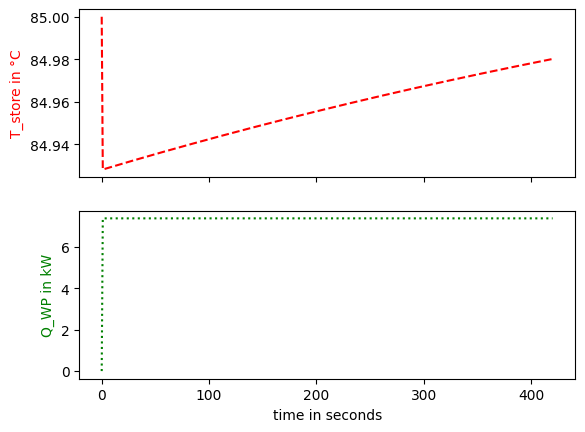

Min operating time= 7.0 minutes
Max operating time= 7.0 minutes
Number of times heat pump was switched on= 1


In [46]:
n = 7*60 #number of times 
op_times1=list() #list for operating times

time=0 #HP is not running at the t=0
WP=0 #
t1,Q_WPs1,T1 = T_store(t_w_min,t_w_max,mw,n,op_times1)

if time!=0:
    op_times1.append(time)
print("Min operating time=",round(min(op_times1)/60.,2),"minutes")
print("Max operating time=",round(max(op_times1)/60.,2),"minutes")
print("Number of times heat pump was switched on=",len(op_times1))